# 模型融合
将多个模型预测结果按照一定规则融合起来，主要方法包括：
- 平均：回归
    - 直接平均
    - 加权平均
- 投票：分类
    - 简单投票
    - 加权投票
- 综合
    - 排序融合
    - log融合
- stacking：构建多层模型，利用预测结果再拟合预测？
    
- blending：选取部分数据预测训练得到预测结果作为新特征，带入剩下的数据中预测

- boosting/bagging

## 融合方法样例
在简单数据集上熟悉各个融合方法的使用

### 回归
评估指标：MAE

In [1]:
from sklearn.metrics import mean_absolute_error

model1_pred = [1.2, 3.2, 2.2, 5.7]
model2_pred = [0.7, 3.1, 2.4, 5.8]
model3_pred = [1.1, 2.9, 1.9, 6.0]

y_true = [1, 3, 2, 6]

# 查看各个模型预测结果
print('--------------MAE--------------')
print('Model1:{}'.format(mean_absolute_error(y_true, model1_pred)))
print('Model2:{}'.format(mean_absolute_error(y_true, model2_pred)))
print('Model3:{}'.format(mean_absolute_error(y_true, model3_pred)))

--------------MAE--------------
Model1:0.22500000000000003
Model2:0.25000000000000006
Model3:0.07500000000000007


#### 直接平均

In [2]:
import numpy as np

def mean_method(preds):
    arrays = np.array([np.array(pred) for pred in preds])
    return np.mean(arrays,axis=0)

mean_res = mean_method([model1_pred,model2_pred,model3_pred])
print('Mean res:',mean_res)
print('True res:',np.array(y_true))
print('Mean pred MAE:{}'.format(mean_absolute_error(y_true, mean_res)))

Mean res: [1.         3.06666667 2.16666667 5.83333333]
True res: [1 3 2 6]
Mean pred MAE:0.10000000000000009


对比结果来看可以发现直接平均效果不如第3个model单独的效果

#### 加权平均
加权平均依据模型预测结果进行权重分配，这里采用`mae`倒数

In [3]:

def weighted_method(preds, scores):
    weights = [score/sum(scores) for score in scores]
    arrays  = [np.array(pred)*weight for pred, weight in zip(preds,weights)]
    return np.sum(arrays, axis=0)

model_preds = [model1_pred, model2_pred, model3_pred]
scores = [1/mean_absolute_error(y_true, pred) for pred in model_preds]
weighted_res = weighted_method(model_preds, scores)
print('Weighted pred MAE:{}'.format(mean_absolute_error(y_true,weighted_res)))

Weighted pred MAE:0.050000000000000044


可以发现通过加权融合得到的结果的确比单个模型效果好

### 投票
包含硬投票（少数服从多数），软投票（投票概率平均），硬投票容易出现虽然有多个分类器投给A类，但是每个分类器A类的概率并不高（0.6），B类虽然投的分类器少，但是每个分类器B类的概率高（0.9）

采用鸢尾花数据集作为分类器投票数据集

In [4]:
from sklearn.datasets import load_iris

from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier  # 投票分类器
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
X_train.shape, X_test.shape

((105, 4), (45, 4))

#### 硬投票（简单投票）

In [5]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score

clf1 = LogisticRegression(random_state=1, max_iter=500)
clf2 = RandomForestClassifier(random_state=1)
clf3 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, min_child_weight=2, subsample=0.7,objective='binary:logistic')

vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='hard')

for name, clf in zip(['logistic','rf', 'xgb','voting'],[clf1, clf2, clf3, vclf]):
    clf = clf.fit(X_train,y_train)
    print('{} acc:{}'.format(name, accuracy_score(y_test, clf.predict(X_test))))


logistic acc:0.9555555555555556
rf acc:0.9333333333333333
xgb acc:0.9555555555555556
voting acc:0.9555555555555556


#### 软投票（加权投票）

In [6]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, min_child_weight=2, subsample=0.7,objective='binary:logistic')
 
vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft', weights=[2, 1, 1])
for name, clf in zip(['logistic','rf', 'xgb','voting'],[clf1, clf2, clf3, vclf]):
    clf = clf.fit(X_train,y_train)
    print('{} acc:{}'.format(name, accuracy_score(y_test, clf.predict(X_test))))

logistic acc:0.9555555555555556
rf acc:0.9333333333333333


d:\python3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


xgb acc:0.9555555555555556
voting acc:0.9555555555555556


d:\python3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


结果没有体现出投票的优越性，估计是数据集太简单

### stacking
stacking主要有两层训练和预测的过程
- 第一层训练采用原始训练集、测试集（验证集）数据，同时采用多个不同的模型，每个模型都能得到一套在训练集上的预测结果$P_i$(i对应模型i)和测试集上的预测结果$T_i$。
- 将第一层训练得到的所有$P_i$组合形成新的训练集，$T_i$组合形成新的测试集。用新的训练集训练模型，同时在新的测试集上测试。

缓解过拟合
- 第二层用的训练模型选择简单线性模型
- 第一层训练模型采用交叉验证的方式（如下图）
> 下面的图包含不同模型在训练集（图1）、测试集（图2）上的操作
    - 对于训练集上训练时，采用5折交叉验证，将验证集的结果拼接得到完整的训练集上的预测结果$P_i$（新的特征）再将这些特征组合作为训练集在第二层模型上训练
    - 对于测试集，每折的训练集模型都对应产生一套预测结果，将这些结果求和取平均得到第二层预测的$T_i$,再见这些$T_i$组合作为新测试集让第二层模型预测
![stacking.png](https://img-blog.csdnimg.cn/2020091301240256.png)
![](https://img-blog.csdnimg.cn/20200401152249882.png)

更具体的内容可以看下面这张图：
例如模型1是`xgb`,模型2是`lgb`,...。
- 训练阶段：训练得到的结果中每个黄框是`n*1`（交叉验证每一份样本数是n）预测得到的是对每一份样本分类的概率，将这些概率全部组合得到第二层的训练集，选择其中一份作为验证集。
- 测试阶段：预测得到的是所有样本的分类概率（根据每折训练集训练得到模型预测概率结果取平均）`m*1`，再将这些结果组合形成第二层测试集用于给第二层训练得到模型进行预测。
![](https://img-blog.csdnimg.cn/20200401152449444.png)


In [7]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# 训练数据预测结果作为新特征输入，相当于[3.2,2.9,3.1] -> 3
train_pred1 = [3.2, 8.2, 9.1, 5.2]
train_pred2 = [2.9, 8.1, 9.0, 4.9]
train_pred3 = [3.1, 7.9, 9.2, 5.0]

# 训练数据真实结果
train_y_true = [3, 8, 9, 5]

# 测试数据预测结果
test_pred1 = [1.2, 3.2, 2.1, 6.2]
test_pred2 = [0.9, 3.1, 2.0, 5.9]
test_pred3 = [1.1, 2.9, 2.2, 6.0]

# 测试数据真实结果
test_y_true = [1, 3, 2, 6]


def stacking_method(train_preds,train_y_true,test_preds,model_L2= LinearRegression()):
    model_L2.fit(np.array([train_pred1, train_pred2, train_pred3]).T,train_y_true)
    Stacking_result = model_L2.predict(np.array(test_preds).T)
    return Stacking_result
 
# # 第二层的模型采用简单线性回归
# model_L2 = LinearRegression()
# Stacking_pre = Stacking_method(train_reg1, train_reg2, train_reg3, y_train_true,
#                                test_pre1, test_pre2, test_pre3, model_L2)
# print('Stacking_pre MAE:', mean_absolute_error(y_test_true, Stacking_pre))

stacking_pred = stacking_method([train_pred1, train_pred2, train_pred3],train_y_true, [test_pred1, test_pred2, test_pred3])
print('----------MAE---------')
print('test1 MAE:', mean_absolute_error(test_y_true, test_pred1))
print('test2 MAE:', mean_absolute_error(test_y_true, test_pred2))
print('test3 MAE:', mean_absolute_error(test_y_true, test_pred3))
print('stacking MAE:', mean_absolute_error(test_y_true, stacking_pred))

----------MAE---------
test1 MAE: 0.1750000000000001
test2 MAE: 0.07499999999999993
test3 MAE: 0.10000000000000009
stacking MAE: 0.042134831460675204


可以看到stacking对于结果是有提升的,上面的过程中省略了第一层的训练测试，用假设的模型预测结果进行第二层的训练。下面采用已有的stacking工具，进行回归和分类的操作

#### stacking：回归
用波士顿房价数据测试`StackingCVRegressor`效果
- StackingCVRegressor（regressors，meta_regressor，cv = 5，shuffle = True，use_features_in_secondary = False）
    - regressors: 基回归器，列表的形式，所有要进行stacking的模型，第一层的模型， 例如xgb和lgb，[xgb, lgb]
    - meta_regressor: 元回归器， 这个可以理解为第二层的那个模型，即将前面回归器结果合起来的那个回归器，直接采用线性回归
    - cv: 交叉验证策略， 默认是5折交叉验证
    - use_features_in_secondary: 默认是False， 意思是第二层的回归器只接收第一层回归器的结果进行训练和预测，如果设置为true，意思是第二层的回归器不仅接收第一层回归器的结果，还接收原始的数据集一块进行训练。
    - shuffle：如果设置为true， 则在交叉验证之前的训练数据将在拟合阶段打乱顺序。

In [8]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.datasets import load_boston

boston = load_boston()
X = boston.data
y = boston.target
X.shape, y.shape

((506, 13), (506,))

In [10]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

def build_xgb_model(X_train, y_train):
    model = XGBRegressor(n_estimators=200,
                        learning_rate=0.1,
                        max_depth=7,
                        subsample=0.8,
                        colsample_bytree=0.9)
    model.fit(X_train, y_train)
    return model

def build_lgb_model(X_train, y_train):
    model = LGBMRegressor(n_estimators=400,
                          learning_rate=0.1, 
                          objective='regression_l1')
    model.fit(X_train, y_train)
    return model

def build_stack_model(X_train, y_train, regressors, lr=LinearRegression()):
    model = StackingCVRegressor(regressors=regressors, meta_regressor=lr)
    model.fit(X_train, y_train)
    return model


In [13]:
# xgb
xgb_model = build_xgb_model(X_train, y_train)
print('XGB MAE:{}'.format(mean_absolute_error(y_test, xgb_model.predict(X_test))))

lgb_model = build_lgb_model(X_train, y_train)
print('LGB MAE:{}'.format(mean_absolute_error(y_test, lgb_model.predict(X_test))))

# stack
xgb = XGBRegressor(n_estimators=400,
                        learning_rate=0.1,
                        max_depth=7,
                        subsample=0.8,
                        colsample_bytree=0.9)
lgb = LGBMRegressor(n_estimators=400,
                          learning_rate=0.1, 
                          objective='regression_l1')
stack_model = build_stack_model(X_train,y_train,[xgb, lgb])
print('Stacking MAE:{}'.format(mean_absolute_error(y_test,stack_model.predict(X_test))))

XGB MAE:1.7408589306999662
LGB MAE:1.8312380680760862
Stacking MAE:1.7073373654154247


可以看到stacking的确是有提升的

#### stacking：分类
采用鸢尾花数据集测试分类中`stacking`的效果

In [24]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_learning_curves, plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

iris = load_iris()
X = iris.data[:,1:3]
y = iris.target
X.shape, y.shape

((150, 2), (150,))

Accuracy: 0.91 (+/- 0.07) [KNN]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [Naive Bayes]
Accuracy: 0.93 (+/- 0.03) [Stacking Classifier]


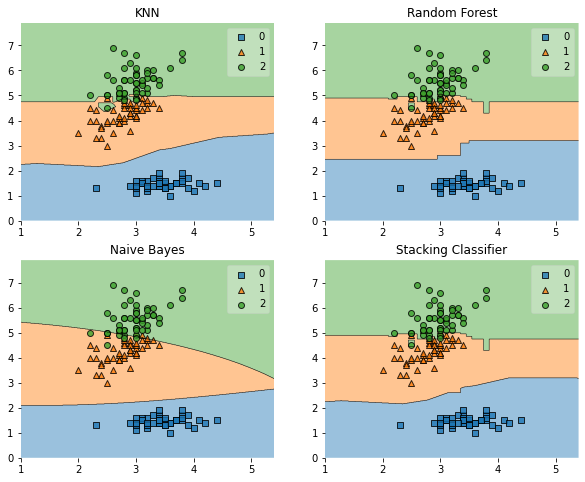

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)


clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf)
    plt.title(label)
 

plt.show()

### blending
本质上和`stacking`没啥区别，通过对训练集做拆分，一部分用于训练一部分用于测试将测试的结果作为特征进入第二层训练
![blending.png](https://img-blog.csdnimg.cn/20200913012401958.png)

## 融合方法应用
将融合方法应用到本次比赛中